# Using GCM to solve a simplified version of Pearl's example

In [223]:
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### Creating the GCM

#### Setting the DAG

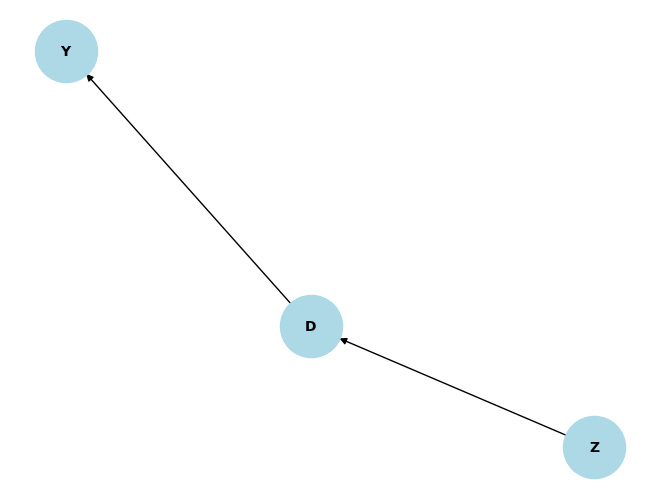

In [224]:
causal_graph = nx.DiGraph([
    ('Z', 'D'),
    ('D', 'Y')
])

causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

#### Setting the causal mechanisms

In [225]:
# Since Z is an exogenous variable, we can set its distribution to be empirical
# For D and Y, we can set their causal mechanisms to be classifiers, which can be trained on data

#From the documentation:
#ClassifierGCM represents the categorical functional causal model of the form
#Y = f(D, N),
#where D is the input (typically, direct causal parents of Y) and the noise N here is uniform on [0, 1]. 
#The model is mostly based on a standard classification model that outputs probabilities. 
#In order to generate a new random sample given an input x, the return value y is uniformly sampled based on the class probabilities p(y | x). 
#Here, the noise is used to make this sampling process deterministic by using the cumulative distribution functions defined by the given inputs.

causal_model.set_causal_mechanism('Z', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('D', gcm.ClassifierFCM())
causal_model.set_causal_mechanism('Y', gcm.ClassifierFCM())

#### Retrieving data

In [226]:
data = pd.read_csv("../../data/balke_pearl.csv")
data.rename(columns={'X': 'D'}, inplace=True)
data = data.astype(str)
print(data.head())

   Z  D  Y
0  0  0  0
1  0  0  0
2  0  0  0
3  0  0  0
4  0  0  0


#### Fitting the model and generating new data

In [227]:
gcm.fit(causal_model, data)
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
print(generated_data.head())

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 25.13it/s]

   Z  D  Y
0  0  1  1
1  0  0  0
2  0  1  0
3  0  1  0
4  0  1  1


### Calculating the ACE

In [228]:
gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'D': lambda x: '1'},
                         interventions_reference={'D': lambda x: '0'},
                         num_samples_to_draw=1000)


### Estimating confidence intervals (Confidence level = 0.95)

In [229]:
gcm.confidence_intervals(lambda: gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'D': lambda x: '1'},
                         interventions_reference={'D': lambda x: '0'},
                         num_samples_to_draw=1000))

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:00<00:00, 33.50it/s]


(array([0.23471357]), array([[0.20545, 0.27   ]]))

Since we removed the unobserved confounder, we can say:
$$ E[Y| do(D=0)] = P(Y=1|D=0) $$
$$ E[Y| do(D=1)] = P(Y=1|D=1) $$
So we can calculate the ACE by doing:
$$ P(Y=1|D=1) - P(Y=1|D=0) = 0.5 - 0.26 = 0.24 $$

Since we found a value close to 0.24, the result can be considered satisfactory.